In [1]:
import os
os.chdir("..")

from src.data_loader import DatabaseConnection

In [2]:
db_connection = DatabaseConnection(
    ssh_host='www.redesign777.tokyo',
    ssh_port=22,
    ssh_user='rddev',
    ssh_password='rdDev@20240521',
    db_host='localhost',
    db_port=3306,
    db_user='rddev',
    db_password='rdSql@20240521',
    db_name='redesign'
)
db_connection.start_tunnel()

2024-08-30 02:08:05,797| ERROR   | Password is required for key C:\Users\yshim/.ssh\id_rsa


SSHトンネルが 64460 にバインドされました。


In [3]:
# クエリを実行
df_frame = db_connection.execute_query("SELECT * FROM re_m_frame")
df_katashiki = db_connection.execute_query("SELECT * FROM re_m_katashiki")
df_pachinko = db_connection.execute_query("SELECT * FROM re_m_katashikidetailpachinko")
df_slot = db_connection.execute_query("SELECT * FROM re_m_katashikidetailslot")
df_katashiki_frame_relation = db_connection.execute_query("SELECT * FROM re_m_katashikiframerelation")
df_maker = db_connection.execute_query("SELECT * FROM re_m_maker")
df_model_evaluation = db_connection.execute_query("SELECT * FROM re_m_modelevaluation")
df_pachinko_type = db_connection.execute_query("SELECT * FROM re_m_pachinkotype")
df_pachinko_type_detail = db_connection.execute_query("SELECT * FROM re_m_pachinkotypedetail")
# SSHトンネルを閉じる
db_connection.close_tunnel()

SSHトンネルを閉じました。


In [4]:
from src.data_preprocessing import data_preprocessing_operator
import configparser

config = configparser.ConfigParser()
config.read('config.ini')

# start_date :　抽出データ開始日
# end_date : 抽出データ終了日
# openai_api_key : openaiのAPIキー
# use_existing_brand : 既存のブランドデータを使うかどうか
# brand_output_path : 抽出したブランドリストを出力するパス

data_model = data_preprocessing_operator(start_date="2020/01/01 00:00:00",
                                        end_date="2024/08/20 23:59:59",
                                        openai_api_key=config['openai']['api_key'],
                                        use_existing_brand=True,
                                        brand_output_path='brand_lists/brand_list_20200101_20240820.csv')

existing_brand_path = 'brand_lists/brand_list_20200101_20240616.csv'

df = data_model.process( 
                df_frame,
                df_katashiki,
                df_pachinko,
                df_slot,
                df_katashiki_frame_relation,
                df_model_evaluation,
                df_pachinko_type,
                df_pachinko_type_detail, existing_brand_path)

In [5]:
cols = df.columns.tolist()

targets = [
     'Performance',
     'Spec',
     'Content',
     'News',
     'Concept',
     'Period',
     'SaleUnit_eval',
     'Running',
     'Returns',
     'Price_eval']

features = [col for col in cols if col not in targets + ['Name', 'ModelLife', 'ModelLife_category', 'GrossProfit', 'GrossProfit_category', 'KatashikiId', 'Regist_Date', 'Color', 'TypeName', 'TypeName_detail', 'brand_name']]


In [6]:
import pandas as pd

print('特徴量の数: ', len(features))

df = df[df['GrossProfit'] > 0]
df = df[df['ModelLife'] > 0]

# 学習とテストデータの定義
df_train = df[df['Regist_Date'] < df['Regist_Date'].min() + pd.DateOffset(days=365*4 - 90)]
df_test = df[df['Regist_Date'] >= df['Regist_Date'].min() + pd.DateOffset(days=365*4 - 90)]

特徴量の数:  164


In [7]:
len(df)

447

In [8]:
print(len(df_train), len(df_test))
print(len(df_train)/ len(df))

390 57
0.87248322147651


# 対数変換

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_hist(data, bins=30):
    plt.figure(figsize=(10, 4))
    plt.hist(data, bins=bins, color='skyblue', edgecolor='black')
    
    plt.xlabel('Value', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.show()

In [10]:
len(df)

447

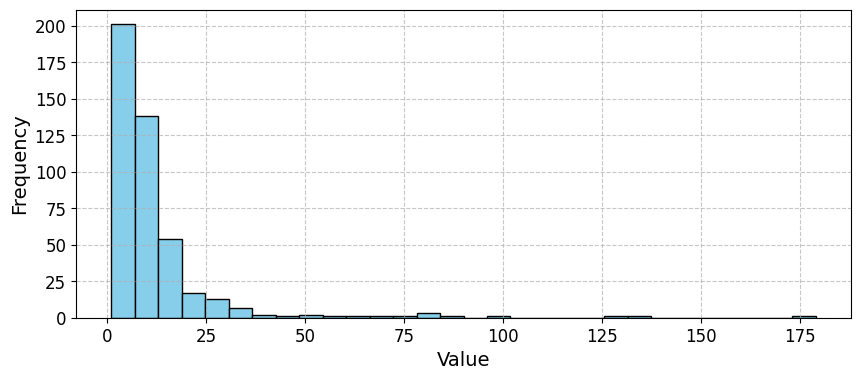

In [11]:
plot_hist(df['ModelLife'].tolist())

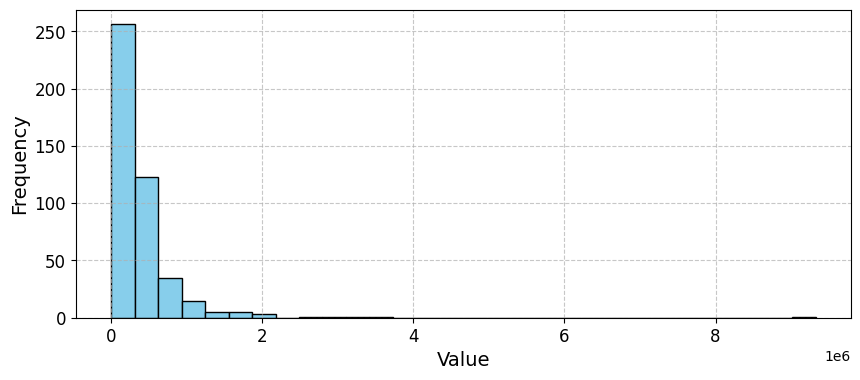

In [12]:
plot_hist(df['GrossProfit'].tolist(), bins=30)

In [13]:
import numpy as np
modellife_min = df['ModelLife'].min()
modellife_avg = df['ModelLife'].mean()

grossprofit_min = df['GrossProfit'].min()

df['ModelLife_log'] = df['ModelLife'].apply(lambda x : np.log(x))
df['GrossProfit_log'] = df['GrossProfit'].apply(lambda x : np.log(x))

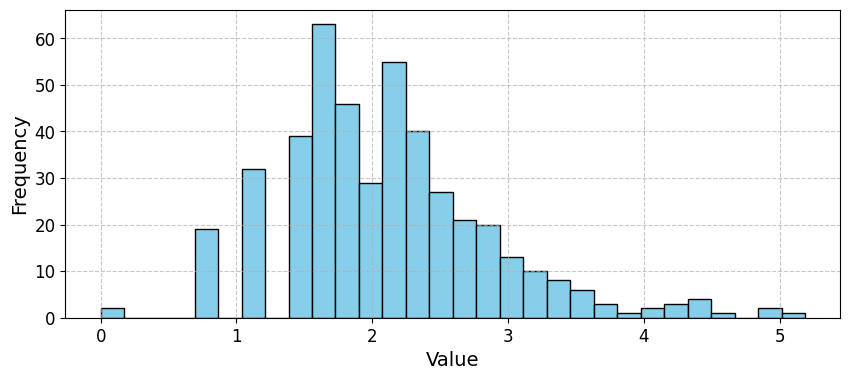

In [14]:
plot_hist(df['ModelLife_log'].tolist())

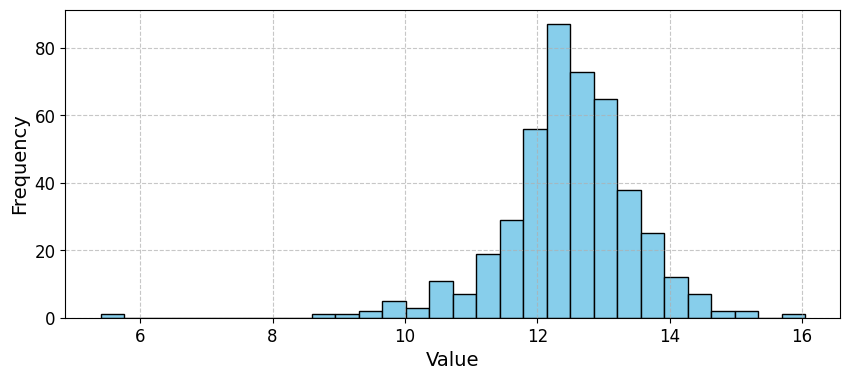

In [15]:
plot_hist(df['GrossProfit_log'].tolist())

# 対数変換なしで回帰予測

In [16]:
def categorize_modellife(x):
    if x >= 0 and x <= 6:
        return 1
    elif x >= 7 and x <= 9:
        return 2
    elif x >= 10 and x <= 13:
        return 3
    elif x >= 14 and x <= 17:
        return 4
    else:
        return 5

def categorize_grossprofit(x):
    if x <= 200000:
        return 1
    elif x > 200000 and x <= 300000:
        return 2
    elif x > 300000 and x <= 400000:
        return 3
    elif x > 400000 and x <= 600000:
        return 4
    elif x > 600000 and x <= 800000:
        return 5
    else:
        return 6

In [17]:
#from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, accuracy_score

df_output = df_test[['ModelLife_category', 'GrossProfit_category']].copy()
models = {}
for target in ['ModelLife', 'GrossProfit']: # 元のデータにフィッテイング
    
    #model = RandomForestRegressor(random_state=42)
    model = LGBMRegressor(random_state=42, verbose=-1)
    model.fit(df_train[features], df_train[target])
    models[target] = model
    y_pred = model.predict(df_test[features])

    df_output[target+'_pred'] = y_pred
    func = categorize_modellife if target == 'ModelLife' else categorize_grossprofit
    df_output[target+'_category' + '_pred'] = df_output[target+'_pred'].apply(lambda x : func(x))

    # 順位に意味があるので、距離で測る
    rmse = mean_squared_error(df_output[target + '_category'], df_output[target+'_category' + '_pred'], squared=False)
    # 一応、正解率も。。
    accuracy = accuracy_score(df_output[target + '_category'], df_output[target+'_category' + '_pred'])

    print(target)
    print('RMSE:', rmse)
    print('正解率:', accuracy)
    print(df_output[target+ '_category'+'_pred'].value_counts())
    print('---------------')

ModelLife
RMSE: 2.70801280154532
正解率: 0.17543859649122806
ModelLife_category_pred
5    31
4     7
3     7
2     6
1     6
Name: count, dtype: int64
---------------
GrossProfit
RMSE: 2.0347852164769096
正解率: 0.19298245614035087
GrossProfit_category_pred
4    19
3    11
2     8
1     8
6     6
5     5
Name: count, dtype: int64
---------------


[0, 0] [5, 6] [6, 7]


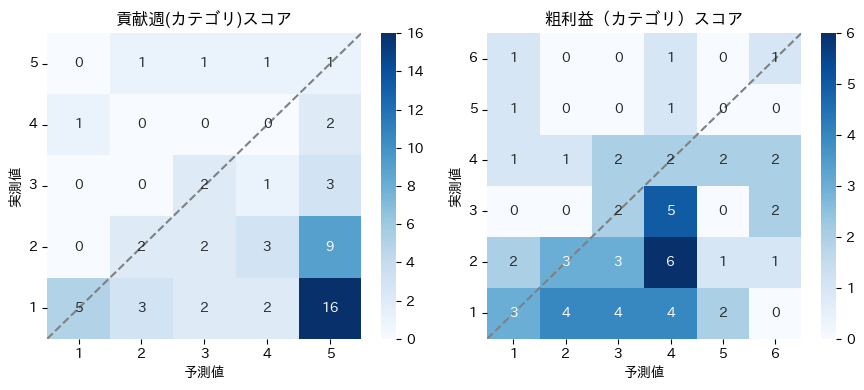

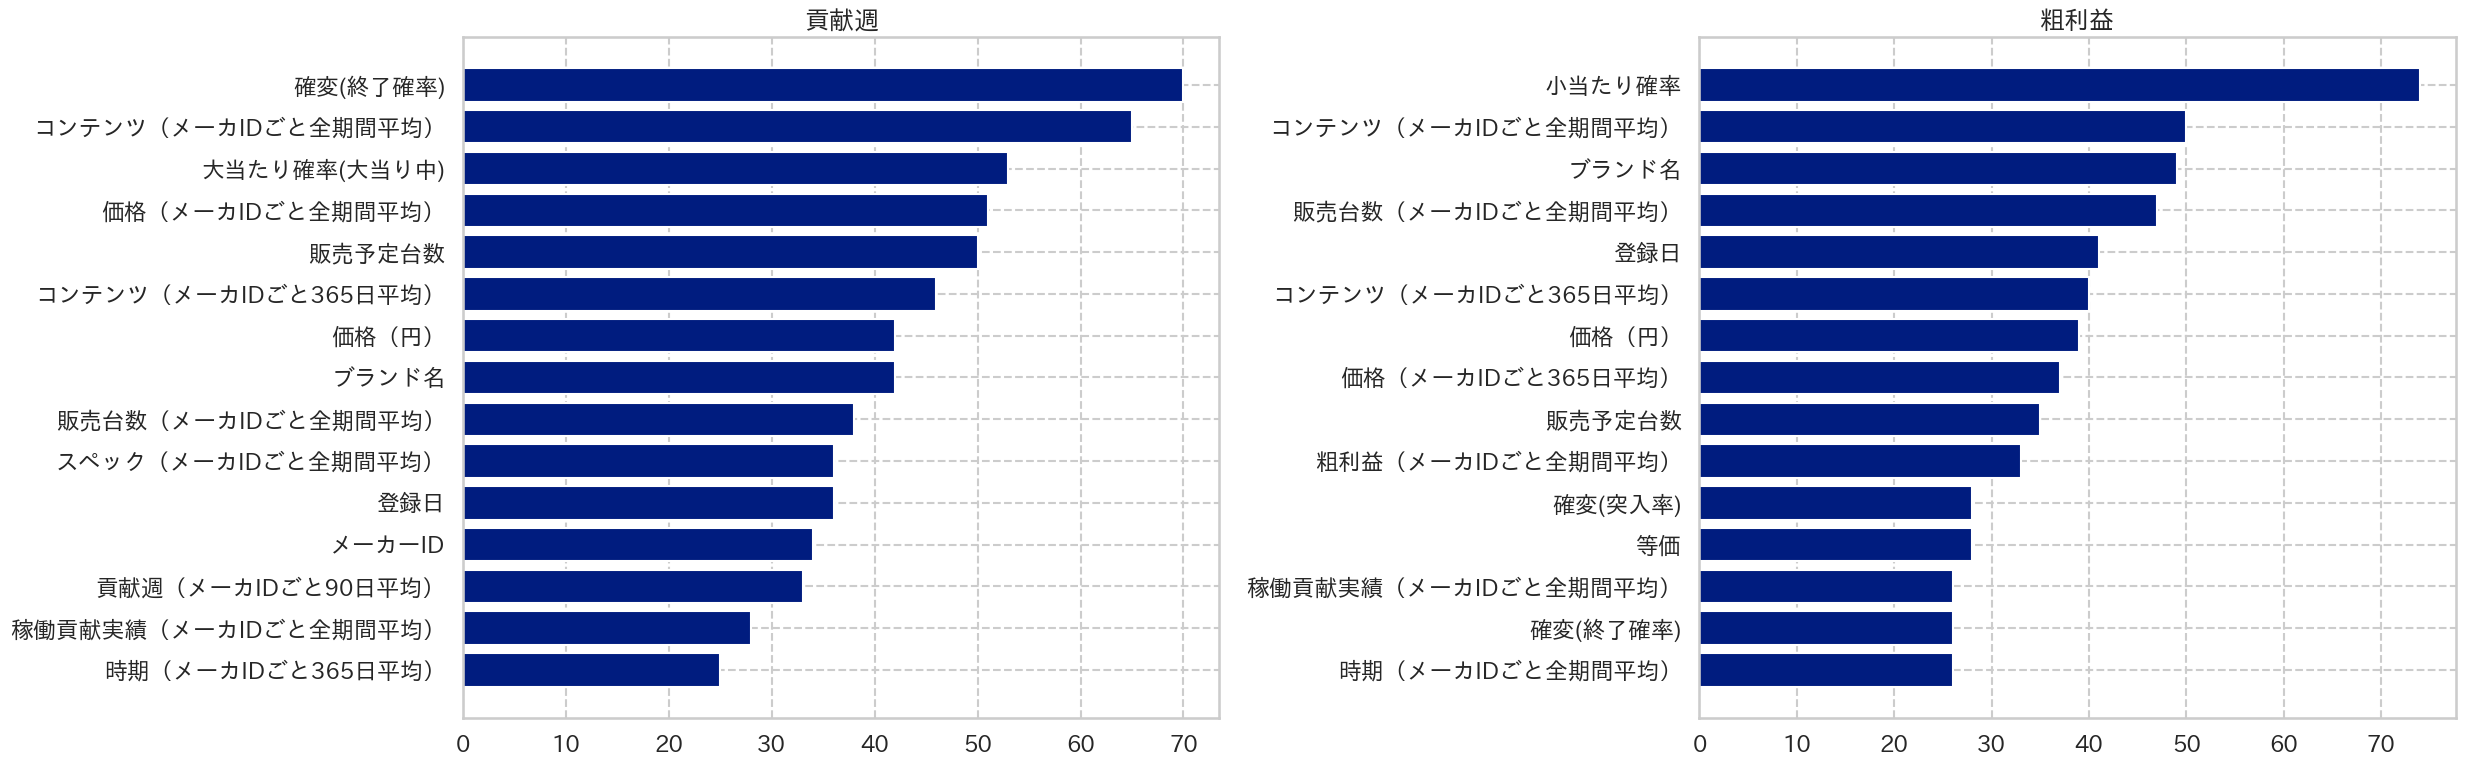

In [18]:
from src.evaluation import evaluation

eval = evaluation(None, None)
fig_heatmap = eval.make_multiple_heatmaps(df_output, [0, 0], [5, 6], N=[6, 7],
                                          targets=['ModelLife_category', 'GrossProfit_category'],
                                          fig_N_rows=1, fig_N_cols=2, figsize=(9, 4), label_decimals=0)

fig_importance = eval.plot_feature_importance(models, targets=['ModelLife', 'GrossProfit'],
                                         features=features, N=15, fig_N_rows=1, fig_N_cols=2, figsize=(25, 8))


# 対数変換後の値にフィッテイング（回帰）

In [19]:
df_train['ModelLife_log'] = df_train['ModelLife'].apply(lambda x : np.log(x))
df_train['GrossProfit_log'] = df_train['GrossProfit'].apply(lambda x : np.log(x))

In [20]:
#from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, accuracy_score

df_output = df_test[['ModelLife_category', 'GrossProfit_category']].copy()
models = {}
for target in ['ModelLife', 'GrossProfit']:
    
    model = LGBMRegressor(random_state=42, verbose=-1, max_depth=15, n_estimators=400, learning_rate=0.09, num_leaves=30)
    model.fit(df_train[features], df_train[target + '_log'])
    models[target] = model
    y_pred = model.predict(df_test[features])

    df_output[target+'_log_pred'] = y_pred
    # 元の値に戻す
    df_output[target+'_pred'] = df_output[target + '_log_pred'].apply(lambda x : np.exp(x))
    
    func = categorize_modellife if target == 'ModelLife' else categorize_grossprofit
    df_output[target+'_category' + '_pred'] = df_output[target+'_pred'].apply(lambda x : func(x))

    # 順位に意味があるので、距離で測る
    rmse = mean_squared_error(df_output[target + '_category'], df_output[target+'_category' + '_pred'], squared=False)
    # 一応、正解率も。。
    accuracy = accuracy_score(df_output[target + '_category'], df_output[target+'_category' + '_pred'])

    print(target)
    print('RMSE:', rmse)
    print('正解率:', accuracy)
    print(df_output[target+ '_category'+'_pred'].value_counts())
    print('---------------')

ModelLife
RMSE: 2.4530682541766184
正解率: 0.24561403508771928
ModelLife_category_pred
5    20
1    15
2    13
3     6
4     3
Name: count, dtype: int64
---------------
GrossProfit
RMSE: 1.7721035176289737
正解率: 0.2982456140350877
GrossProfit_category_pred
2    19
3    12
1    10
4     9
5     5
6     2
Name: count, dtype: int64
---------------


[0, 0] [5, 6] [6, 7]


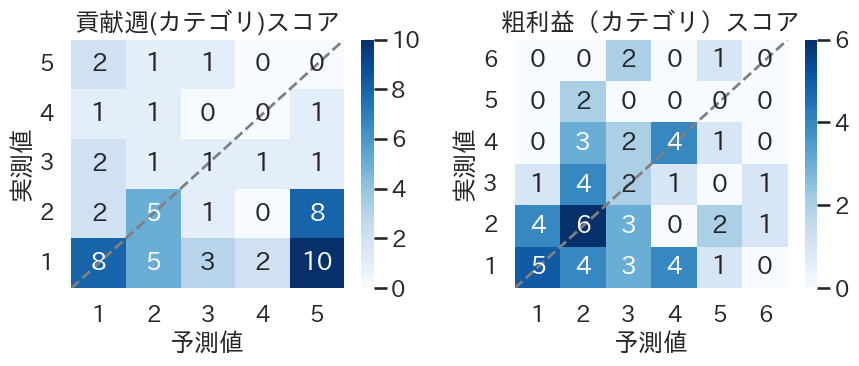

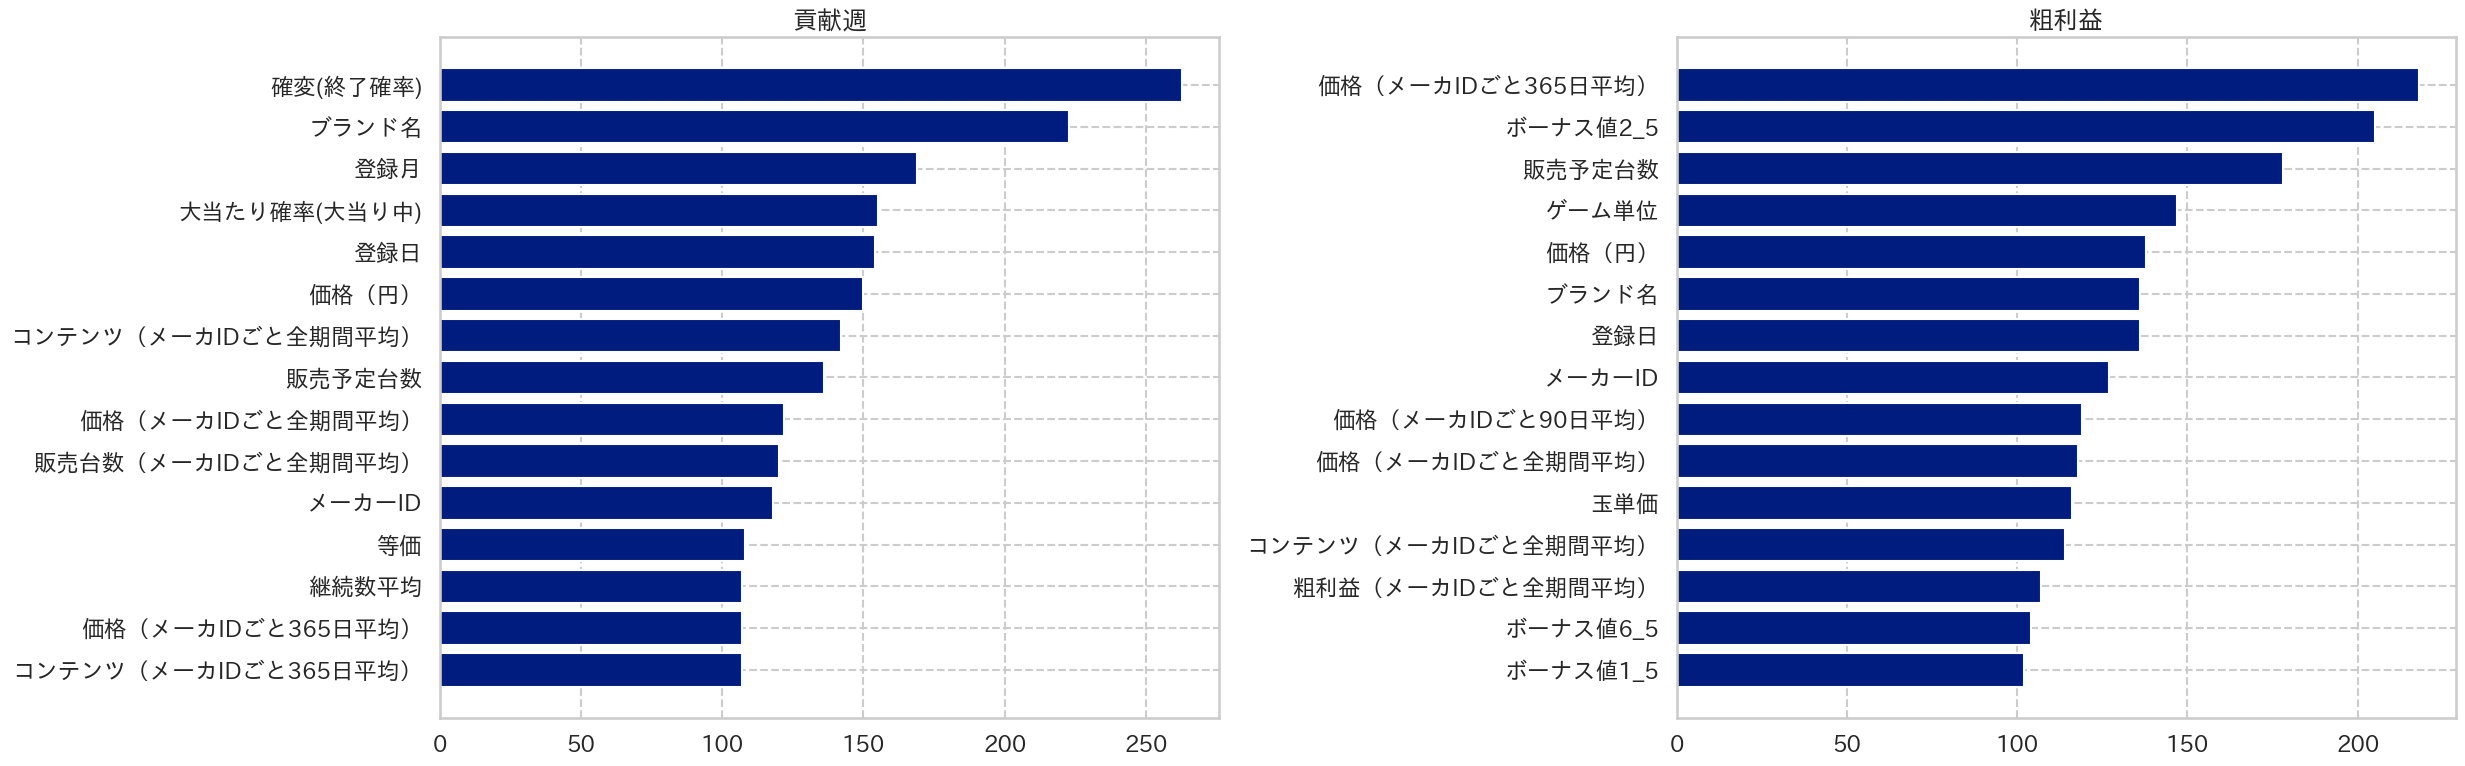

In [21]:
from src.evaluation import evaluation

eval = evaluation(None, None)
fig_heatmap = eval.make_multiple_heatmaps(df_output, [0, 0], [5, 6], N=[6, 7],
                                          targets=['ModelLife_category', 'GrossProfit_category'],
                                          fig_N_rows=1, fig_N_cols=2, figsize=(9, 4), label_decimals=0)

fig_importance = eval.plot_feature_importance(models, targets=['ModelLife', 'GrossProfit'],
                                         features=features, N=15, fig_N_rows=1, fig_N_cols=2, figsize=(25, 8))


# 上記の回帰モデルをチューニング

In [22]:
from src.hyperparameters_tuning import model_tuning

# lightgbm
mt_gbm = model_tuning(file_path='hyperparameters/best_parameters_profit_lightgbm_testing.json')
mt_gbm.tune_models(features, ['ModelLife_log', 'GrossProfit_log'], df_train, model_kind='lightgbm_regressor', n_trials=1000)


最適化: minimize  rmse
--- ModelLife_log ---
trial: 612
rmse : 0.7245759019237298
ベストパラメータ: {'boosting_type': 'gbdt', 'num_leaves': 48, 'max_depth': 8, 'learning_rate': 0.01083963621789522, 'n_estimators': 106, 'min_child_samples': 21, 'min_child_weight': 0.032507429018769095, 'subsample': 0.6880686082781139, 'colsample_bytree': 0.5463804100034412, 'reg_alpha': 0.07828370281802954, 'reg_lambda': 1.145474965101036, 'max_bin': 100, 'lambda_l1': 1.8118036559173922, 'lambda_l2': 1.0801973038823915}
--- GrossProfit_log ---
trial: 998
rmse : 0.6560358078569812
ベストパラメータ: {'boosting_type': 'gbdt', 'num_leaves': 22, 'max_depth': 7, 'learning_rate': 0.010604709817204856, 'n_estimators': 154, 'min_child_samples': 27, 'min_child_weight': 0.04020222928424546, 'subsample': 0.5174240358793967, 'colsample_bytree': 0.978841592477609, 'reg_alpha': 0.08432129818835761, 'reg_lambda': 1.6695062653158046, 'max_bin': 181, 'lambda_l1': 0.8034653532592458, 'lambda_l2': 0.23187274931257743}


In [23]:
from src.modeling import modeling
m = modeling(features, targets=['ModelLife_log', 'GrossProfit_log'])

# lightgbm
models_profit_gbm = m.load_and_train_all(df_train,
                              param_path='hyperparameters/best_parameters_profit_lightgbm_testing.json',
                              model_kind='lightgbm_regressor')

df_output = df_test[['ModelLife_category', 'GrossProfit_category']].copy()
for target in ['ModelLife', 'GrossProfit']:
    y_pred = models_profit_gbm[target+'_log'].predict(df_test[features])

    df_output[target+'_log_pred'] = y_pred
    # 元の値に戻す
    df_output[target+'_pred'] = df_output[target + '_log_pred'].apply(lambda x : np.exp(x))
    
    func = categorize_modellife if target == 'ModelLife' else categorize_grossprofit
    df_output[target+'_category' + '_pred'] = df_output[target+'_pred'].apply(lambda x : func(x))

    # 順位に意味があるので、距離で測る
    rmse = mean_squared_error(df_output[target + '_category'], df_output[target+'_category' + '_pred'], squared=False)
    # 一応、正解率も。。
    accuracy = accuracy_score(df_output[target + '_category'], df_output[target+'_category' + '_pred'])

    print(target)
    print('RMSE:', rmse)
    print('正解率:', accuracy)
    print(df_output[target+ '_category'+'_pred'].value_counts())
    print('---------------')

ModelLife
RMSE: 2.004381166257836
正解率: 0.22807017543859648
ModelLife_category_pred
2    38
5    15
3     3
1     1
Name: count, dtype: int64
---------------
GrossProfit
RMSE: 1.504379571363837
正解率: 0.2982456140350877
GrossProfit_category_pred
3    27
2    16
1    10
4     4
Name: count, dtype: int64
---------------


In [27]:
models_profit_gbm['ModelLife'] = models_profit_gbm.pop('ModelLife_log')
models_profit_gbm['GrossProfit'] = models_profit_gbm.pop('GrossProfit_log')

eval = evaluation(None, None)
fig_heatmap = make_multiple_heatmaps(df_output, [0, 0], [5, 6], N=[6, 7],
                                          targets=['ModelLife_category', 'GrossProfit_category'],
                                          fig_N_rows=1, fig_N_cols=2, figsize=(9, 4), label_decimals=0)

fig_importance = plot_feature_importance(models_profit_gbm, targets=['ModelLife', 'GrossProfit'],
                                         features=features, N=15, fig_N_rows=1, fig_N_cols=2, figsize=(25, 8))


[0, 0] [5, 6] [6, 7]


NameError: name 'self' is not defined

# チューニングのメトリックを変える

In [41]:
import optuna
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import json
import lightgbm as lgb
from sklearn.metrics import f1_score

class model_tuning_dev:
    def __init__(self, file_path):
        self.file_path = file_path
        self.model = None

    def objective(self, trial, features, target,
                  df, model_kind='random_forest_regressor', loss='rmse'):
        
        if model_kind == 'random_forest_regressor' or model_kind == 'random_forest_classifier':
            params = params = {
                'n_estimators': trial.suggest_int('n_estimators', 90, 300), 
                'max_depth': trial.suggest_int('max_depth', 3, 20), 
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10), 
                'max_features': trial.suggest_uniform('max_features', 0.3, 1.0), 
                'bootstrap': trial.suggest_categorical('bootstrap', [True]),  
                #'criterion': trial.suggest_categorical('criterion', ['mse', 'mae']),  
                'min_weight_fraction_leaf': trial.suggest_uniform('min_weight_fraction_leaf', 0.0, 0.2),  
                'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 50, 600), 
                'min_impurity_decrease': trial.suggest_uniform('min_impurity_decrease', 0.0, 0.2),  
                'random_state': 42  # Fixed random state for reproducibility
            }

        elif model_kind == 'lightgbm_regressor' or model_kind == 'lightgbm_classifier':
            # 今は範囲を狭くとっている
            params = {
                "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt"]), #"gbdt", "dart", "goss"
                "num_leaves": trial.suggest_int("num_leaves", 20, 50),
                "max_depth": trial.suggest_int("max_depth", 3, 15),
                "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.3, log=True),
                "n_estimators": trial.suggest_int("n_estimators", 100, 400), 
                "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
                "min_child_weight": trial.suggest_float("min_child_weight", 0.0005, 0.05),
                "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 2.0),
                "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 2.0),
                "max_bin": trial.suggest_int("max_bin", 100, 255),
                "lambda_l1": trial.suggest_float("lambda_l1", 0, 2.0),
                "lambda_l2": trial.suggest_float("lambda_l2", 0, 2.0),
                "random_state" : 42,
                "verbose" : -1,
            }
        
        df = df.sort_values(by='Regist_Date')
        
        X = df[features]
        y = df[target]

        # データ数が少ないため、交差検証を一旦避ける
        #tscv = TimeSeriesSplit(n_splits=3)

        #rmse_list = []
        #for train_index, test_index in tscv.split(X):
        split_N = int(0.8 * len(X))
        train_x, test_x = X.iloc[:split_N], X.iloc[split_N:]
        train_y, test_y = y.iloc[:split_N], y.iloc[split_N:]
        
        if model_kind == 'random_forest_regressor':
            self.model = RandomForestRegressor(**params)
        elif model_kind == 'random_forest_classifier':
            self.model = RandomForestClassifier(**params)
        elif model_kind == 'lightgbm_regressor':
            self.model = lgb.LGBMRegressor(**params)
        elif model_kind == 'lightgbm_classifier':
            self.model = lgb.LGBMClassifier(**params)

        self.model.fit(train_x, train_y)
        preds = self.model.predict(test_x)

        if loss == 'rmse':
            loss_value = mean_squared_error(test_y, preds, squared=False)
        elif loss == 'f1_macro':
            loss_value = f1_score(test_y, preds, average='macro')
        elif loss == 'f1_weighted':
            loss_value = f1_score(test_y, preds, average='weighted')
        elif loss == 'f1_weighted_special':
            if target == 'ModelLife_log':
                preds_categorized = [categorize_modellife(np.exp(x)) for x in preds]
                test_y_categorized = [categorize_modellife(np.exp(x)) for x in test_y.to_numpy()]
            elif target == 'GrossProfit_log':
                preds_categorized = [categorize_grossprofit(np.exp(x)) for x in preds]
                test_y_categorized = [categorize_grossprofit(np.exp(x)) for x in test_y.to_numpy()]
            
            loss_value = f1_score(test_y_categorized, preds_categorized, average='weighted')
        #loss_value_list.append(loss_value)

        #mean_loss = np.mean(loss_value_list)
        trial.set_user_attr(loss, loss_value)
        
        return loss_value

    def tune_models(self, features, targets, df, model_kind='random_forest_regressor', n_trials=200, loss='rmse'):
        dict_output = {}

        if loss == 'rmse':
            direction = 'minimize'
        else:
            direction = 'maximize'

        print('最適化:', direction, '', loss)
        for target in targets:
            print('---', target, '---')
            study = optuna.create_study(direction='minimize',
                                        sampler=optuna.samplers.TPESampler(seed=42))
            
            study.optimize(lambda x: self.objective(x, features, target, df, model_kind=model_kind, loss=loss),
                        n_trials=n_trials)

            best_trial = study.best_trial

            dict_output[target] = {}
            dict_output[target]['best_trial_num'] = best_trial.number
            dict_output[target]['best_rmse'] = best_trial.value
            dict_output[target]['best_params'] = self.model.set_params(**best_trial.params).get_params()

            print('trial:', best_trial.number)
            print(loss, ':', best_trial.value)
            print('ベストパラメータ:', best_trial.params)

        with open(self.file_path, 'w', encoding='utf-8') as f:
            json.dump(dict_output, f, ensure_ascii=False, indent=4)

In [38]:
def categorize_modellife(x):
    if x >= 0 and x <= 6:
        return 1
    elif x >= 7 and x <= 9:
        return 2
    elif x >= 10 and x <= 13:
        return 3
    elif x >= 14 and x <= 17:
        return 4
    else:
        return 5

def categorize_grossprofit(x):
    if x <= 200000:
        return 1
    elif x > 200000 and x <= 300000:
        return 2
    elif x > 300000 and x <= 400000:
        return 3
    elif x > 400000 and x <= 600000:
        return 4
    elif x > 600000 and x <= 800000:
        return 5
    else:
        return 6

In [42]:
# lightgbm
mt_gbm = model_tuning_dev(file_path='hyperparameters/best_parameters_profit_lightgbm_testing_2.json')
mt_gbm.tune_models(features, ['ModelLife_log', 'GrossProfit_log'], df_train, model_kind='lightgbm_regressor', n_trials=500, loss='f1_weighted_special')


最適化: maximize  f1_weighted_special
--- ModelLife_log ---
trial: 189
f1_weighted_special : 0.028161297392066624
ベストパラメータ: {'boosting_type': 'gbdt', 'num_leaves': 23, 'max_depth': 3, 'learning_rate': 0.010780311321761838, 'n_estimators': 100, 'min_child_samples': 13, 'min_child_weight': 0.043103489724144746, 'subsample': 0.9397812834462217, 'colsample_bytree': 0.5675287188528039, 'reg_alpha': 0.009508198723457706, 'reg_lambda': 0.6236721530762966, 'max_bin': 221, 'lambda_l1': 0.2411315413928254, 'lambda_l2': 1.508780809857059}
--- GrossProfit_log ---
trial: 405
f1_weighted_special : 0.08659722776317534
ベストパラメータ: {'boosting_type': 'gbdt', 'num_leaves': 36, 'max_depth': 15, 'learning_rate': 0.033571734495556595, 'n_estimators': 163, 'min_child_samples': 15, 'min_child_weight': 0.04577006025182442, 'subsample': 0.8752517076922036, 'colsample_bytree': 0.6289821508378423, 'reg_alpha': 1.4658561360687246, 'reg_lambda': 0.5714576056824902, 'max_bin': 163, 'lambda_l1': 1.0107561311990603, 'lambd

In [43]:
from src.modeling import modeling
m = modeling(features, targets=['ModelLife_log', 'GrossProfit_log'])

# lightgbm
models_profit_gbm = m.load_and_train_all(df_train,
                              param_path='hyperparameters/best_parameters_profit_lightgbm_testing_2.json',
                              model_kind='lightgbm_regressor')

df_output = df_test[['ModelLife_category', 'GrossProfit_category']].copy()
for target in ['ModelLife', 'GrossProfit']:
    y_pred = models_profit_gbm[target+'_log'].predict(df_test[features])

    df_output[target+'_log_pred'] = y_pred
    # 元の値に戻す
    df_output[target+'_pred'] = df_output[target + '_log_pred'].apply(lambda x : np.exp(x))
    
    func = categorize_modellife if target == 'ModelLife' else categorize_grossprofit
    df_output[target+'_category' + '_pred'] = df_output[target+'_pred'].apply(lambda x : func(x))

    # 順位に意味があるので、距離で測る
    rmse = mean_squared_error(df_output[target + '_category'], df_output[target+'_category' + '_pred'], squared=False)
    # 一応、正解率も。。
    accuracy = accuracy_score(df_output[target + '_category'], df_output[target+'_category' + '_pred'])

    print(target)
    print('RMSE:', rmse)
    print('正解率:', accuracy)
    print(df_output[target+ '_category'+'_pred'].value_counts())
    print('---------------')

ModelLife
RMSE: 1.7697670670735495
正解率: 0.22641509433962265
ModelLife_category_pred
2    42
5     9
1     1
3     1
Name: count, dtype: int64
---------------
GrossProfit
RMSE: 1.5171970183377075
正解率: 0.3018867924528302
GrossProfit_category_pred
3    21
2    16
1     9
4     7
Name: count, dtype: int64
---------------


[0, 0] [5, 6] [6, 7]


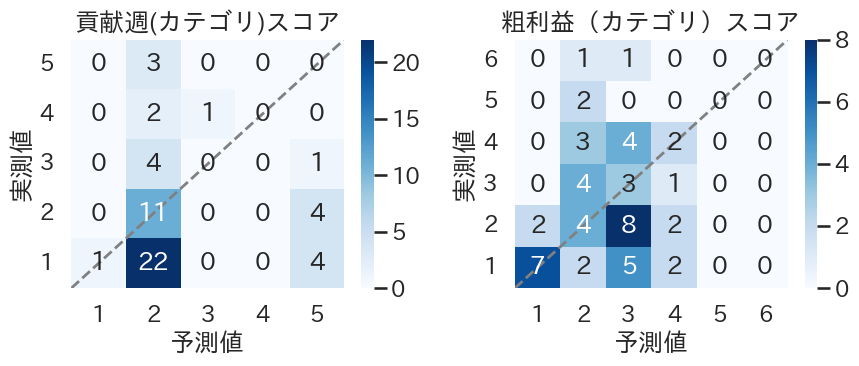

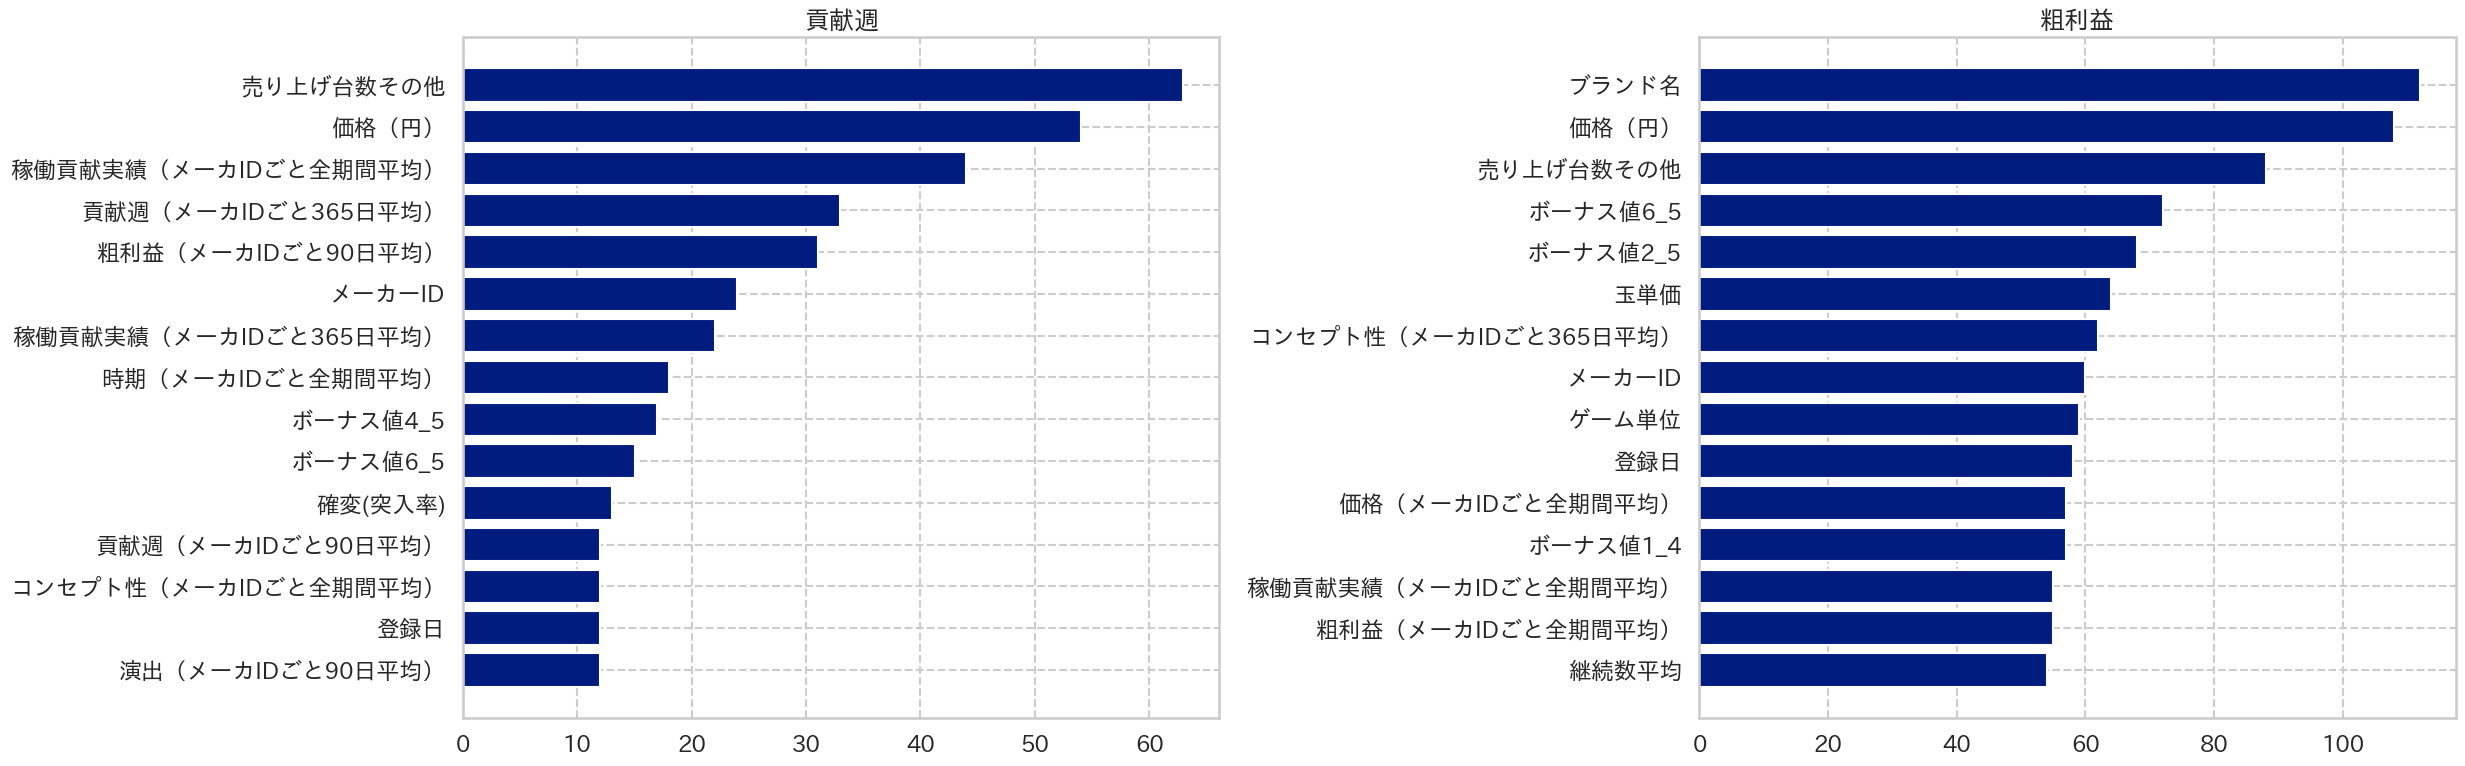

In [44]:
from src.evaluation import evaluation

models_profit_gbm['ModelLife'] = models_profit_gbm.pop('ModelLife_log')
models_profit_gbm['GrossProfit'] = models_profit_gbm.pop('GrossProfit_log')

eval = evaluation(None, None)
fig_heatmap = eval.make_multiple_heatmaps(df_output, [0, 0], [5, 6], N=[6, 7],
                                          targets=['ModelLife_category', 'GrossProfit_category'],
                                          fig_N_rows=1, fig_N_cols=2, figsize=(9, 4), label_decimals=0)

fig_importance = eval.plot_feature_importance(models_profit_gbm, targets=['ModelLife', 'GrossProfit'],
                                         features=features, N=15, fig_N_rows=1, fig_N_cols=2, figsize=(25, 8))


# マルチクラスの予測

[0, 0] [5, 6] [6, 7]


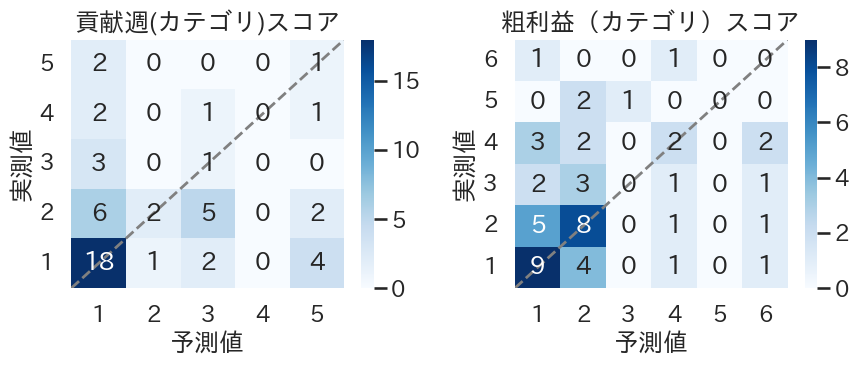

     targets      RMSE       正解率
0  貢献週(カテゴリ)  1.804135  0.431373
1  粗利益（カテゴリ）  1.868207  0.372549


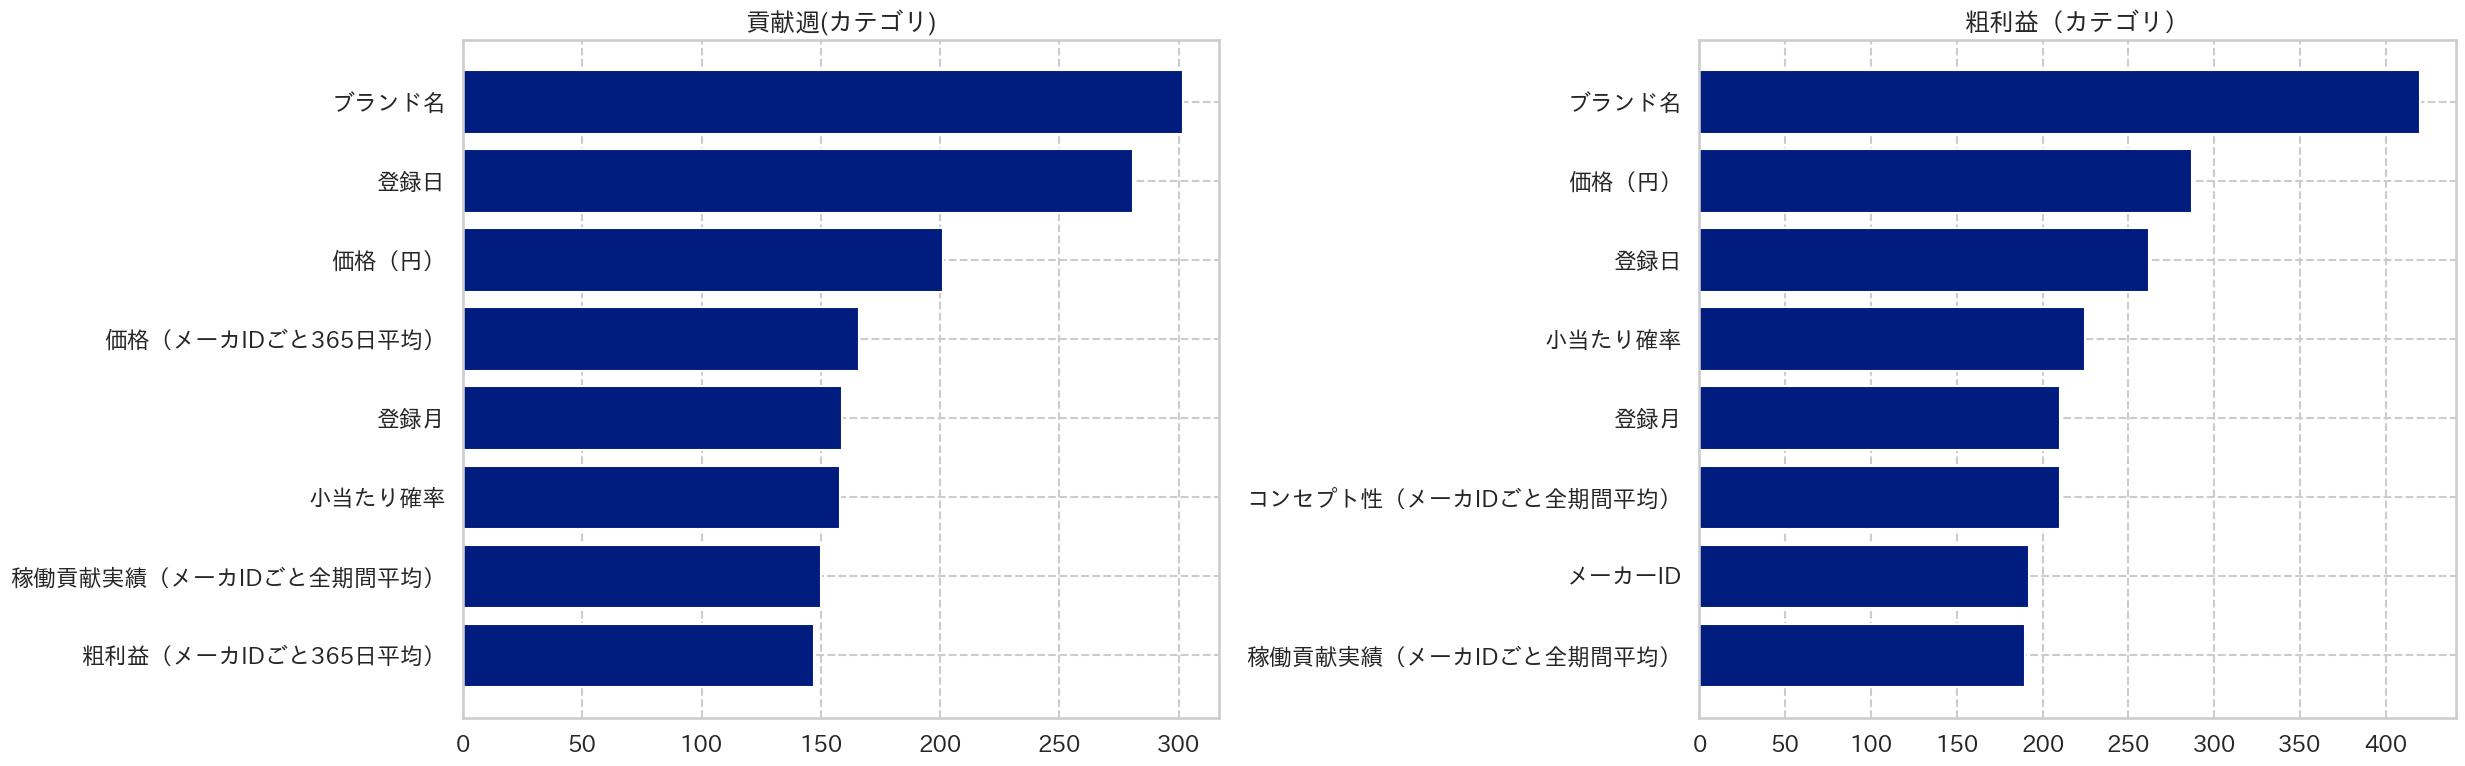

In [30]:
m = modeling(features, targets=['ModelLife_category', 'GrossProfit_category'])
models = m.train_all(df_train, all_params=None, model_kind='lightgbm_classifier')
df_output = m.predict_all(models, df_test)

eval = evaluation(None, None)
df1, df2, df3 = eval.evaluate_all(df_output, targets=['ModelLife_category', 'GrossProfit_category'], eval_types=['rmse', 'accuracy'])
fig_heatmap = eval.make_multiple_heatmaps(df_output, [0, 0], [5, 6], N=[6, 7],
                                          targets=['ModelLife_category', 'GrossProfit_category'],
                                          fig_N_rows=1, fig_N_cols=2, figsize=(9, 4), label_decimals=0)

fig_importance = eval.plot_feature_importance(models, targets=['ModelLife_category', 'GrossProfit_category'],
                                         features=features, N=8, fig_N_rows=1, fig_N_cols=2, figsize=(25, 8))

print(df1)

# マルチクラスのチューニング

In [19]:
from src.hyperparameters_tuning import model_tuning

# lightgbm
mt_gbm = model_tuning(file_path='hyperparameters/best_parameters_profit_gbm_testing.json')
mt_gbm.tune_models(features, ['ModelLife_category', 'GrossProfit_category'], df_train, model_kind='lightgbm_classifier', n_trials=1000, loss='f1_weighted')

最適化: maximize
--- ModelLife_category ---
trial: 899
f1_weighted : 0.28101649140291546
ベストパラメータ: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 8, 'learning_rate': 0.2295994150933157, 'n_estimators': 198, 'min_child_samples': 49, 'min_child_weight': 0.047116561206594985, 'subsample': 0.7035198102943274, 'colsample_bytree': 0.9583192019474454, 'reg_alpha': 0.23727709333472619, 'reg_lambda': 0.9823823006891759, 'max_bin': 237, 'lambda_l1': 0.4674375680440227, 'lambda_l2': 0.036519595316930956}
--- GrossProfit_category ---
trial: 910
f1_weighted : 0.10203939895720718
ベストパラメータ: {'boosting_type': 'gbdt', 'num_leaves': 38, 'max_depth': 9, 'learning_rate': 0.23346386725146062, 'n_estimators': 308, 'min_child_samples': 50, 'min_child_weight': 0.035802083857574954, 'subsample': 0.6074320241269766, 'colsample_bytree': 0.9468990578607089, 'reg_alpha': 1.203046391908631, 'reg_lambda': 1.7450966826458176, 'max_bin': 190, 'lambda_l1': 0.21755343928915438, 'lambda_l2': 0.23070792367226312}


[0, 0] [5, 6] [6, 7]


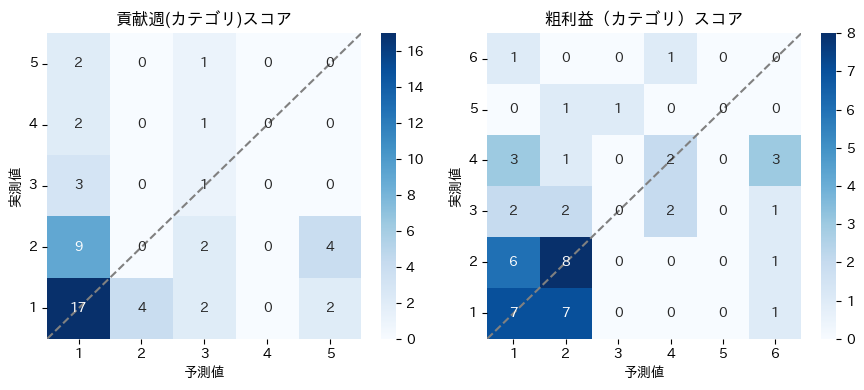

     targets      RMSE   正解率
0  貢献週(カテゴリ)  1.777639  0.36
1  粗利益（カテゴリ）  1.788854  0.34


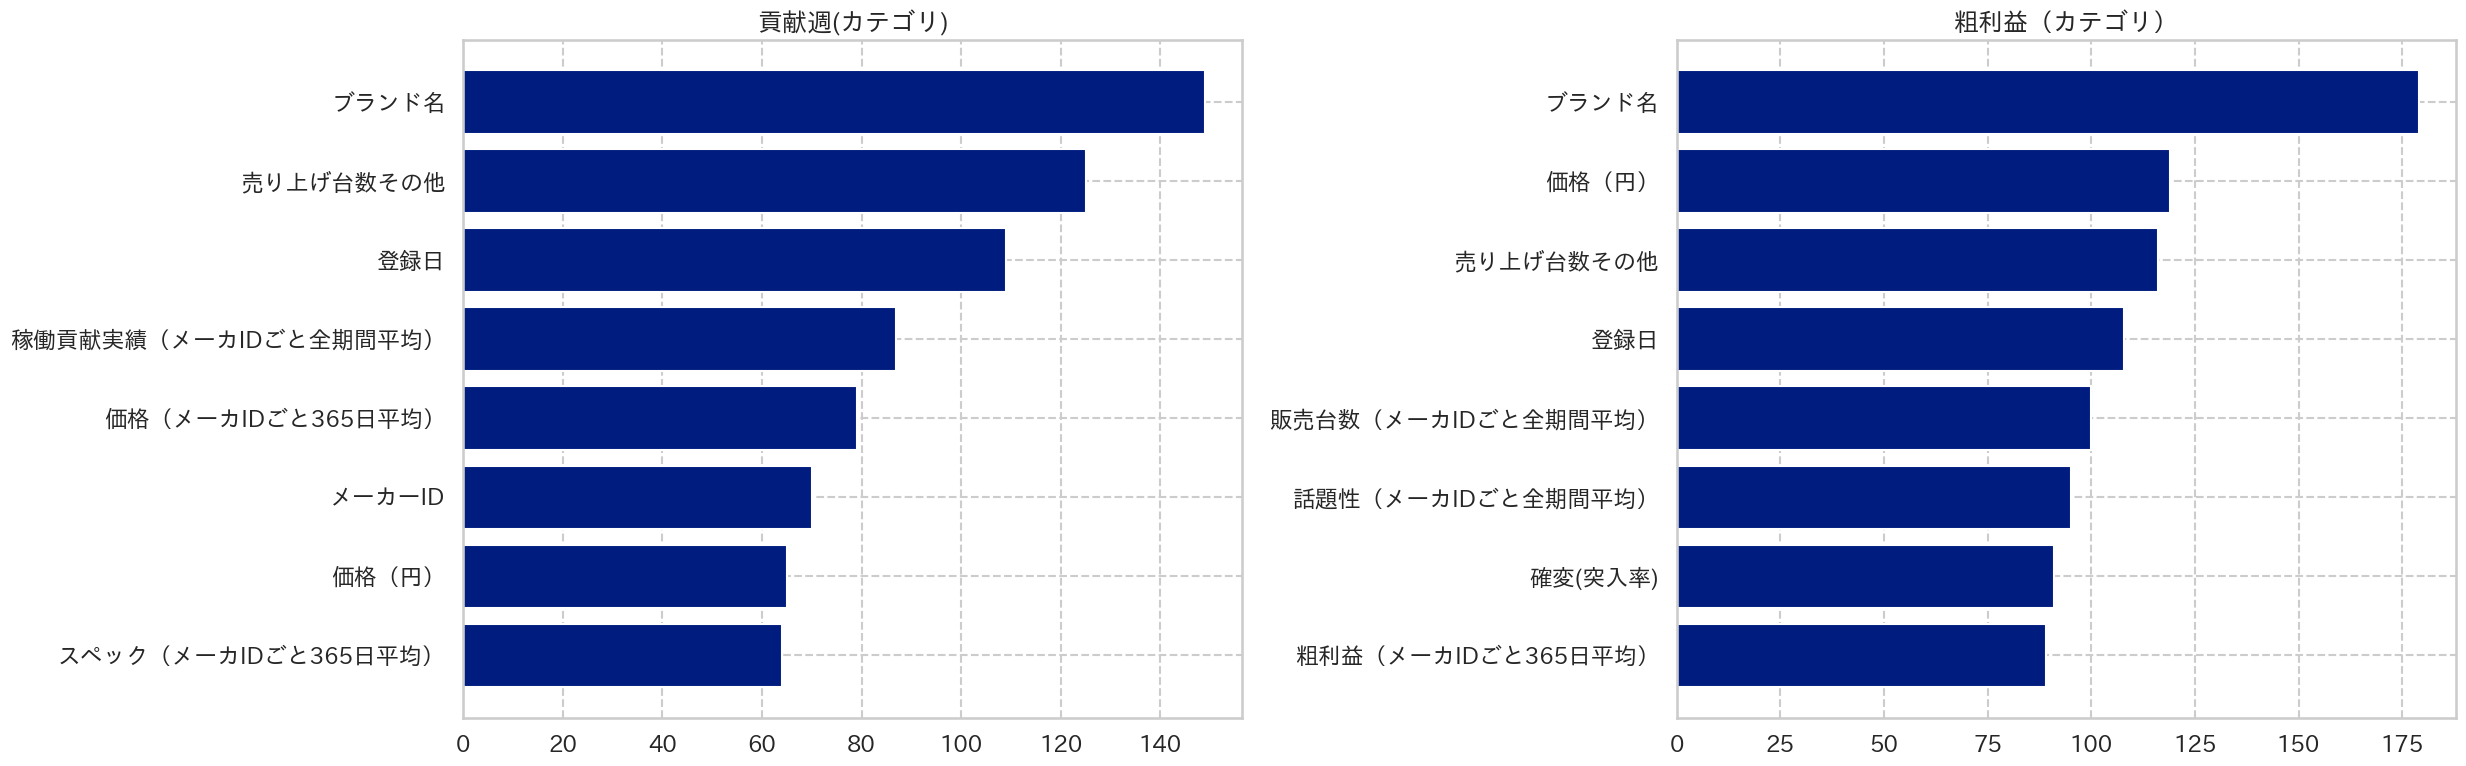

In [20]:
from src.modeling import modeling
from src.evaluation import evaluation

m = modeling(features, ['ModelLife_category', 'GrossProfit_category'])
# 読み込んで学習データに学習、テストデータに推論
models = m.load_and_train_all(df_train,
                              param_path='hyperparameters/best_parameters_profit_gbm_testing.json',
                              model_kind='lightgbm_classifier')
df_output = m.predict_all(models, df_test)

### 評価値 ###
eval = evaluation(None, None)
df1, df2, df3 = eval.evaluate_all(df_output, targets=['ModelLife_category', 'GrossProfit_category'], eval_types=['rmse', 'accuracy'])
fig_heatmap = eval.make_multiple_heatmaps(df_output, [0, 0], [5, 6], N=[6, 7],
                                          targets=['ModelLife_category', 'GrossProfit_category'],
                                          fig_N_rows=1, fig_N_cols=2, figsize=(9, 4), label_decimals=0)

fig_importance = eval.plot_feature_importance(models, targets=['ModelLife_category', 'GrossProfit_category'],
                                         features=features, N=8, fig_N_rows=1, fig_N_cols=2, figsize=(25, 8))

print(df1)